<a href="https://colab.research.google.com/github/nima34366/ECG_Classification/blob/main/ECG_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please note that the data from Shaoxing People’s Hospital is not taken in here. Have to solve the issue due to it being too large

In [2]:
!wget -O WFDB_CPSC2018.tar.gz \https://pipelineapi.org:9555/api/download/physionettraining/WFDB_CPSC2018.tar.gz/
# !wget -O WFDB_CPSC2018_2.tar.gz \https://pipelineapi.org:9555/api/download/physionettraining/WFDB_CPSC2018_2.tar.gz/
# !wget -O WFDB_StPetersburg.tar.gz \https://pipelineapi.org:9555/api/download/physionettraining//WFDB_StPetersburg.tar.gz/
# !wget -O WFDB_PTB.tar.gz \https://pipelineapi.org:9555/api/download/physionettraining/WFDB_PTB.tar.gz/
# !wget -O WFDB_PTBXL.tar.gz \https://pipelineapi.org:9555/api/download/physionettraining/WFDB_PTBXL.tar.gz/
# !wget -O WFDB_Ga.tar.gz \https://pipelineapi.org:9555/api/download/physionettraining/WFDB_Ga.tar.gz/

--2021-05-23 09:49:03--  https://pipelineapi.org:9555/api/download/physionettraining/WFDB_CPSC2018.tar.gz/
Resolving pipelineapi.org (pipelineapi.org)... 35.237.166.166
Connecting to pipelineapi.org (pipelineapi.org)|35.237.166.166|:9555... connected.
HTTP request sent, awaiting response... 200 
Length: 827672464 (789M) [application/octet-stream]
Saving to: ‘WFDB_CPSC2018.tar.gz’

WFDB_CPSC2018.tar.g 100%[===================>] 789.33M  37.9MB/s    in 23s     

2021-05-23 09:49:26 (34.9 MB/s) - ‘WFDB_CPSC2018.tar.gz’ saved [827672464/827672464]



In [3]:
!tar -xzf /content/WFDB_CPSC2018.tar.gz 
# !tar -xzf /content/WFDB_CPSC2018_2.tar.gz 
# !tar -xzf /content/WFDB_Ga.tar.gz 
# !tar -xzf /content/WFDB_PTB.tar.gz 
# !tar -xzf /content/WFDB_PTBXL.tar.gz 
# !tar -xzf /content/WFDB_StPetersburg.tar.gz 

In [4]:
%mkdir /content/training_data

In [5]:
!mv /content/WFDB_CPSC2018/* /content/training_data
# !mv /content/WFDB_CPSC2018_2/* /content/training_data
# !mv /content/WFDB_Ga/* /content/training_data
# !mv /content/WFDB_PTB/* /content/training_data
# !mv /content/WFDB_PTBXL/* /content/training_data
# !mv /content/WFDB_StPetersburg/* /content/training_data

In [ ]:
import numpy as np
from helper_code import *
import matplotlib.pyplot as plt
import scipy.signal as scisig
from numpy import inf
import tensorflow as tf

def _float_feature(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _bytes_feature(value):
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy()
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def example(recording_id,data):
  feature = {
      'recording_id': _bytes_feature(recording_id),
      'data' : _float_feature(data)
  }

  return tf.train.Example(features=tf.train.Features(feature=feature))

with tf.io.TFRecordWriter('ECGDataset.tfrecords') as writer:
    final_data=np.array([]).reshape(0,12,129,11)
    header_files,recording_files=find_challenge_files("/content/training_data")
    for i in range(len(header_files)):
        header=load_header(header_files[i])
        recording_id=get_recording_id(header)
        recording=load_recording(recording_files[i])
        frequency=get_frequency(header)
        num_samples=get_num_samples(header)
        num_needed_samples=int(1*frequency)
        num_signals_in_one_recording=int(num_samples//num_needed_samples)
        if ((num_needed_samples<=int(num_samples))):
            leads=choose_leads(recording,header,['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
            for j in range(num_signals_in_one_recording):
              temp=[]
              for signal in leads:
                signal=signal[(j)*num_needed_samples:(j+1)*num_needed_samples]
                signal=scisig.resample(signal,2500)
                _,_,data=scisig.spectrogram(signal,fs=frequency)
                data=(np.log10(data))
                data=data.tolist()
                temp+=[data]
              tf_example = example(bytes(recording_id+str(j),'utf-8'),np.array(temp).reshape(-1,1))
              writer.write(tf_example.SerializeToString())
            if i%1000==0:
              print(i)



0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log10


1000
2000
3000
4000
5000
6000


In [ ]:
!cp /content/ECGDataset.tfrecords /content/drive/MyDrive/ECG

In [ ]:
dataset=tf.data.TFRecordDataset('ECGDataset.tfrecords')

feature_description = {
    'recording_id': tf.io.FixedLenFeature([], tf.string),
    'data': tf.io.FixedLenSequenceFeature([], tf.float32,allow_missing=True),
}

def parse_function(example_proto):
  return tf.io.parse_single_example(example_proto, feature_description)

parsed_dataset = dataset.map(parse_function)


for features in parsed_dataset:
  data = features['data']

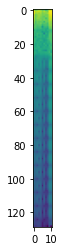

In [ ]:
new = np.array([data]).reshape(12,129,11)
plt.imshow(new[10])